## gpu 사용 여부 확인

In [16]:
!nvidia-smi

Fri Dec 11 15:46:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.43       Driver Version: 456.43       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:07:00.0  On |                  N/A |
| 35%   31C    P5    N/A /  75W |    837MiB /  4096MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

## 라이브러리 import 

In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from urllib import request
from PIL import Image
import urllib.request


transform = transforms.Compose([
        transforms.Resize((224,244), interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 1 #보여주는 1장 이미지 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

dataloaders = {'train' : trainloader, 'val' : testloader }
dataset_sizes = { 'train' : len(trainset) , 'val' : len(testset) }

class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("10가지 카테고리")
print(class_names)

Files already downloaded and verified
Files already downloaded and verified
10가지 카테고리
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [146]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #GPU 사용가능 여부확인
device

device(type='cuda', index=0)

## 일부 이미지 시각화

       bird         car        ship       horse


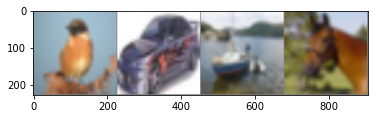

In [19]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('      %5s' % class_names[labels[j]] for j in range(4)))
plt.show() # 4개 정도 이미지

## 모델 정의하기_resnet18

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

In [21]:
model_ft.fc = nn.Linear(num_ftrs, 10).cuda()
model_ft = model_ft.to(device)

## 손실함수와 Optimizer 정의하기

In [22]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training 신경망 학습

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # dataloader로부터 dataset과 그에 해당되는 label을 불러온다.
            for inputs, labels in dataloaders[phase]:  
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림
                # zero the parameter gradients
                optimizer.zero_grad()  #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).cuda()
                    _, preds = torch.max(outputs, 1) 
                    # 마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels).cuda()
                    
                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward()
                        optimizer.step()
                    else:
                        preds=preds.cpu()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                preds = preds.cuda()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


================Finished modeling


In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

Epoch 0/19
--------------------


C:\Users\user\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.7558 Acc: 0.7592
val Loss: 0.3359 Acc: 0.8901

Epoch 1/19
--------------------
train Loss: 0.3938 Acc: 0.8738
val Loss: 0.2708 Acc: 0.9103

Epoch 2/19
--------------------
train Loss: 0.2702 Acc: 0.9148
val Loss: 0.2712 Acc: 0.9118

Epoch 3/19
--------------------
train Loss: 0.2006 Acc: 0.9370
val Loss: 0.2751 Acc: 0.9141

Epoch 4/19
--------------------
train Loss: 0.1525 Acc: 0.9519
val Loss: 0.2442 Acc: 0.9204

Epoch 5/19
--------------------
train Loss: 0.1149 Acc: 0.9641
val Loss: 0.2311 Acc: 0.9265

Epoch 6/19
--------------------
train Loss: 0.0505 Acc: 0.9868
val Loss: 0.1706 Acc: 0.9460

Epoch 7/19
--------------------
train Loss: 0.0307 Acc: 0.9927
val Loss: 0.1653 Acc: 0.9465

Epoch 8/19
--------------------
train Loss: 0.0234 Acc: 0.9949
val Loss: 0.1646 Acc: 0.9485

Epoch 9/19
--------------------
train Loss: 0.0197 Acc: 0.9962
val Loss: 0.1621 Acc: 0.9504

Epoch 10/19
--------------------
train Loss: 0.0203 Acc: 0.9957
val Loss: 0.1649 Acc: 0.9486

Epoch 11

## 모델 저장하기

In [33]:
import joblib
#model_ft.save('resnet18M.h5')
joblib.dump(model_ft, 'resnet18M.h5')

['model18.pkl']

### gpu 메모리를 위한 작업

In [294]:
import gc
from tensorflow.keras.backend import clear_session

del model_ft
clear_session()
gc.collect()

59812